In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline

from model.convlstm import ConvLSTM
from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Load specific variables for each dataset

In [3]:
%run dataset-variables.py

version = 3
dataset = ../data/dataset-chirps-1981-2019-seq5-ystep5.nc
input_size = 50
step = 5
dropout rate = 0.8
learning rate = 0.001
upsample = False
upsample mode = None
param = {'layer_size': 3, 'kernel_size': 3, 'hidden_dim': 64}


In [4]:
util = Util('ConvLSTM', version=version, prefix=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Seed

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Hyperparameters

In [7]:
epochs = 50
batch_size = 50
validation_split = 0.2
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [8]:
ds = xr.open_mfdataset(dataset_file)
#ds = ds[dict(sample=slice(0,500))]

In [9]:
train_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split)
val_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_validation=True)
test_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_test=True)

In [10]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [11]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [12]:
class STConvLSTM(nn.Module):
    def __init__(self, input_size, layer_size, kernel_size, hidden_dim, dropout_rate):
        
        super(STConvLSTM, self).__init__()
        self.dropout_rate = dropout_rate
        self.convlstm_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        input_dim = 1
        for i in range(layer_size):
            self.convlstm_layers.append(
                ConvLSTM(input_size=(input_size,input_size), input_dim=input_dim, 
                        hidden_dim=hidden_dim, kernel_size=(kernel_size,kernel_size), num_layers=1, 
                        bias=False, return_all_layers=True, batch_first=True)
            )
            input_dim = hidden_dim
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(num_features=hidden_dim))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
        
        self.conv_layer = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def learning_with_dropout(self, x):
        for convlstm, relu, batch, drop in zip(self.convlstm_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x, hidden = convlstm(x)
            x = drop(relu(batch(x[0])))
            
        return x
    
    def learning_without_dropout(self, x):
        for convlstm, relu, batch in zip(self.convlstm_layers, self.relu_layers, self.batch_layers):
            x, hidden = convlstm(x)
            x = relu(batch(x[0]))
            
        return x
        
    def forward(self, input_):
        if self.dropout_rate > 0.:
            output = self.learning_with_dropout(input_)
        else:
            output = self.learning_without_dropout(input_)
        
        return self.conv_layer(output)

In [13]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [14]:
model = STConvLSTM(input_size, layer_size, kernel_size, hidden_dim, dropout_rate).to(device)

criterion = RMSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, eps=1e-6)

Training the model

In [15]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                          device, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename)

Train on 8376 samples, validate on 2792 samples
Epoch: 1/50 - loss: 6.7559 - val_loss: 6.5279
=> Saving a new best
Epoch: 2/50 - loss: 6.5625 - val_loss: 6.4953
=> Saving a new best
Epoch: 3/50 - loss: 6.5454 - val_loss: 6.5033
Epoch: 4/50 - loss: 6.5366 - val_loss: 6.4754
=> Saving a new best
Epoch: 5/50 - loss: 6.5305 - val_loss: 6.4906
Epoch: 6/50 - loss: 6.5242 - val_loss: 6.4672
=> Saving a new best
Epoch: 7/50 - loss: 6.5204 - val_loss: 6.4632
=> Saving a new best
Epoch: 8/50 - loss: 6.5181 - val_loss: 6.4676
Epoch: 9/50 - loss: 6.5153 - val_loss: 6.4832
Epoch: 10/50 - loss: 6.5134 - val_loss: 6.4653
Epoch: 11/50 - loss: 6.5115 - val_loss: 6.4992
Epoch: 12/50 - loss: 6.5098 - val_loss: 6.4569
=> Saving a new best
Epoch: 13/50 - loss: 6.5099 - val_loss: 6.4587
Epoch: 14/50 - loss: 6.5079 - val_loss: 6.4866
Epoch: 15/50 - loss: 6.5060 - val_loss: 6.5113
Epoch: 16/50 - loss: 6.5054 - val_loss: 6.4538
=> Saving a new best
Epoch: 17/50 - loss: 6.5057 - val_loss: 6.4607
Epoch: 18/50 - 

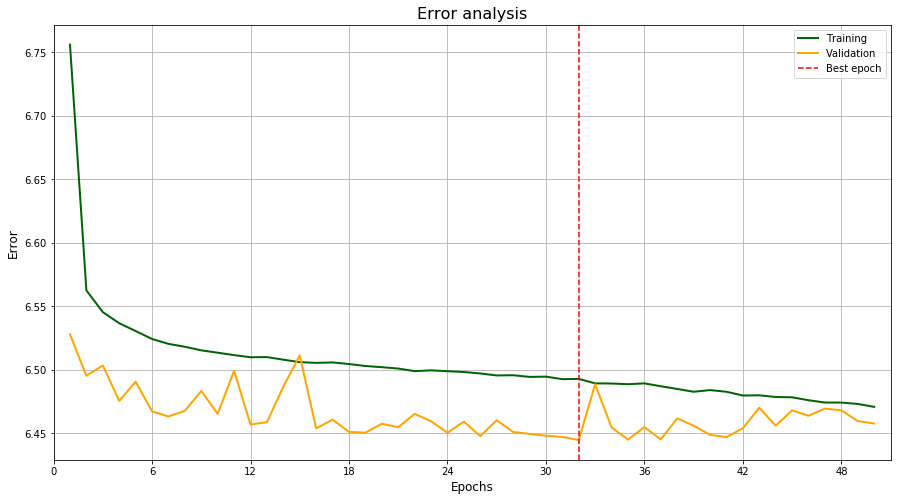

In [16]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Error', 'Error analysis', inline=True)

In [17]:
model,_, best_epoch, val_loss = trainer.load_checkpoint(checkpoint_filename)

=> Loaded checkpoint chirps_3_20191012-024104.pth.tar (best epoch: 32, validation error: 6.4446)


Evaluating the model

In [18]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.eval()
loss_type = type(criterion).__name__
print(f'ConvLSTM {loss_type}: {test_loss:.4f}')

ConvLSTM RMSELoss: 6.4108


In [19]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [21]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'layer': layer_size,
              'kernel_size': kernel_size,
              'filter': hidden_dim,
              'dropout_rate': dropout_rate,
              'learning_rate': lr,
              'dataset': dataset,
              'hostname': platform.node()}

In [22]:
util.send_email(model_info)

timestamp: 6770.869052171707
email sent
